# Урок 5. Персонифицированная и предиктивная медицина

## Домашнее задание.

Изучите https://pyhealth.readthedocs.io/en/latest/index.html
В разделе Tutorials выберите наиболее интересующий вас пайплайн (например, Mortality Prediction) и попробуйте его прогнать на предложенных разработчиками датасетах (графа Datasets) стартовой страницы.
Выберите модель, подходящую для вашей задачи, аргументируйте, почему именно эта модель кажется вам наилучшей. Обучите модель и протестируйте ее, оцените качество.

Возьмем пайплайн `Pipeline 1: Drug Recommendation`.

In [1]:
!pip install pyhealth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.3/226.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 43.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=484a48ecb581bd87a9619df206afb273b584709a6c1c6a07dd5556c7e38a3b64
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


### **Step 1: Load dataset**
- **[README]:** We call [pyhealth.datasets](https://pyhealth.readthedocs.io/en/latest/api/datasets.html) to process and obtain the dataset.
  - `root` is the arguments directing to the data folder.
  - `tables` is a list of table names from raw databases, which specifies the information that will be used in building the pipeline. Currently, we support [MIMIC3Dataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.MIMIC3Dataset.html), [MIMIC4Dataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.MIMIC4Dataset.html), [eICUDataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.eICUDataset.html), [OMOPDataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.OMOPDataset.html).
  - `code_mapping [default: None]` asks a directionary input, specifying the new coding systems for each data table. For example, `{"NDC": ("ATC", {"target_kwargs": {"level": 3}})}` means that our pyhealth will automatically change the codings from `NDC` into ATC-3 level for tables if any.
  - `dev`: if set `True`, will only load a smaller set of patients.
- **[Next Step]:** This `pyhealth.datasets` object will be used in **Step 2**.

In [2]:
from pyhealth.datasets import MIMIC3Dataset

mimic3_ds = MIMIC3Dataset(
        root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
        tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
        code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 3}})},
        dev=False
)

mimic3_ds.stat()

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
finish basic patient information parsing : 90.25709438323975s
finish parsing DIAGNOSES_ICD : 64.72698283195496s
finish parsing PROCEDURES_ICD : 57.11529278755188s
finish parsing PRESCRIPTIONS : 186.43656206130981s


Mapping codes: 100%|██████████| 49993/49993 [00:59<00:00, 842.40it/s]



Statistics of base dataset (dev=False):
	- Dataset: MIMIC3Dataset
	- Number of patients: 49993
	- Number of visits: 52769
	- Number of visits per patient: 1.0555
	- Number of events per visit in DIAGNOSES_ICD: 9.1038
	- Number of events per visit in PROCEDURES_ICD: 3.2186
	- Number of events per visit in PRESCRIPTIONS: 32.9969



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 49993\n\t- Number of visits: 52769\n\t- Number of visits per patient: 1.0555\n\t- Number of events per visit in DIAGNOSES_ICD: 9.1038\n\t- Number of events per visit in PROCEDURES_ICD: 3.2186\n\t- Number of events per visit in PRESCRIPTIONS: 32.9969\n'

In [3]:
# data format
mimic3_ds.info()


dataset.patients: patient_id -> <Patient>

<Patient>
    - visits: visit_id -> <Visit> 
    - other patient-level info
    
    <Visit>
        - event_list_dict: table_name -> List[Event]
        - other visit-level info
    
        <Event>
            - code: str
            - other event-level info



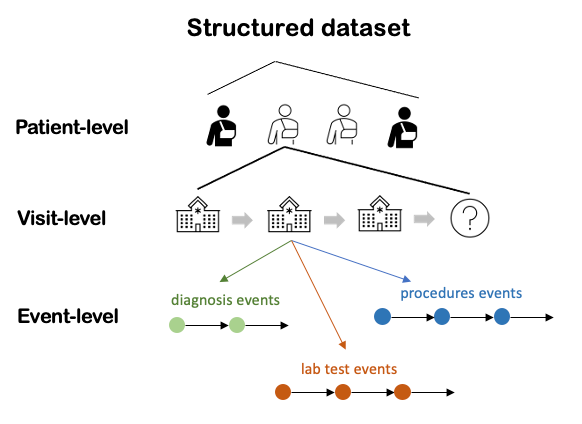

In [4]:
""" check the information """
mimic3_ds.patients
mimic3_ds.patients['947']
mimic3_ds.patients['947'].visits
mimic3_ds.patients['947'].visits['100999']
mimic3_ds.patients['947'].visits['100999'].get_code_list('DIAGNOSES_ICD')

['40390', '3484', '2989']

### **Step 2: Define healthcare task**
- **[README]:** This step assigns a **task function** to the dataset for data loading [pyhealth.tasks](https://pyhealth.readthedocs.io/en/latest/api/tasks.html). The **task function** specifics how to process each pateint's data into a set of samples for the downstream machine learning models.
- **[Next Step]:** This `pyhealth.tasks` object will be used in **Step 3**.

In [5]:
from pyhealth.tasks import drug_recommendation_mimic3_fn

mimic3_ds = mimic3_ds.set_task(task_fn=drug_recommendation_mimic3_fn)
# stats info
mimic3_ds.stat()

Generating samples for drug_recommendation_mimic3_fn: 100%|██████████| 49993/49993 [00:01<00:00, 33357.99it/s]


Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: drug_recommendation_mimic3_fn
	- Number of samples: 1858
	- Number of patients: 911
	- Number of visits: 1858
	- Number of visits per patient: 2.0395
	- conditions:
		- Number of conditions per sample: 16.0759
		- Number of unique conditions: 2146
		- Distribution of conditions (Top-10): [('4019', 1107), ('4280', 755), ('42731', 717), ('41401', 713), ('25000', 659), ('2724', 431), ('5849', 412), ('5990', 393), ('53081', 373), ('2720', 295)]
	- procedures:
		- Number of procedures per sample: 5.9462
		- Number of unique procedures: 659
		- Distribution of procedures (Top-10): [('3893', 642), ('9904', 495), ('3961', 431), ('9604', 327), ('9671', 313), ('966', 309), ('8856', 272), ('3615', 268), ('8872', 242), ('3722', 200)]
	- drugs:
		- Number of drugs per sample: 21.4769
		- Number of unique drugs: 178
		- Distribution of drugs (Top-10): [('B05X', 1393), ('A06A', 1295), ('A02B', 1232), ('B01A', 1195), ('N02B', 1182), ('N0

"Statistics of sample dataset:\n\t- Dataset: MIMIC3Dataset\n\t- Task: drug_recommendation_mimic3_fn\n\t- Number of samples: 1858\n\t- Number of patients: 911\n\t- Number of visits: 1858\n\t- Number of visits per patient: 2.0395\n\t- conditions:\n\t\t- Number of conditions per sample: 16.0759\n\t\t- Number of unique conditions: 2146\n\t\t- Distribution of conditions (Top-10): [('4019', 1107), ('4280', 755), ('42731', 717), ('41401', 713), ('25000', 659), ('2724', 431), ('5849', 412), ('5990', 393), ('53081', 373), ('2720', 295)]\n\t- procedures:\n\t\t- Number of procedures per sample: 5.9462\n\t\t- Number of unique procedures: 659\n\t\t- Distribution of procedures (Top-10): [('3893', 642), ('9904', 495), ('3961', 431), ('9604', 327), ('9671', 313), ('966', 309), ('8856', 272), ('3615', 268), ('8872', 242), ('3722', 200)]\n\t- drugs:\n\t\t- Number of drugs per sample: 21.4769\n\t\t- Number of unique drugs: 178\n\t\t- Distribution of drugs (Top-10): [('B05X', 1393), ('A06A', 1295), ('A02B

In [6]:
mimic3_ds.samples[17]

{'visit_id': '110765',
 'patient_id': '10402',
 'conditions': [['2639',
   '4821',
   '2720',
   '3051',
   '42731',
   '28521',
   '5601',
   '30500',
   '2724',
   '2767',
   '1985',
   '34590',
   '2763',
   '07054',
   '2866',
   '78900',
   '44023',
   '99649'],
  ['51881',
   '5990',
   '4019',
   '5070',
   '7907',
   '5849',
   '5789',
   '42789',
   'E8798',
   '2800',
   'V5861',
   '2875',
   '5856',
   '99883',
   '4538',
   '78052',
   '4275',
   '73390',
   '20410',
   '2841',
   '43320',
   'V8741',
   'V440',
   '99681',
   '99659',
   'V454',
   '2989',
   '51851',
   '43889',
   '49322',
   'V642',
   '56721',
   '5130',
   '78722',
   '72982']],
 'procedures': [['9604', '5185'],
  ['9604',
   '966',
   '3893',
   '9915',
   '4311',
   '5491',
   '3897',
   '3491',
   '560',
   '3324',
   '9723',
   '8191',
   '0014',
   '4516',
   '9925',
   '9390',
   '9229',
   '8851',
   '9906',
   '8754',
   '415']],
 'drugs': ['J01E',
  'A02B',
  'J01X',
  'N03A',
  'N02A',
  'J

Повысим сложность включив перемешивание на всех частях датасета.

In [7]:
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader

# data split
train_dataset, val_dataset, test_dataset = split_by_patient(mimic3_ds, [0.7, 0.15, 0.15])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=64, shuffle=True)
test_loader = get_dataloader(test_dataset, batch_size=64, shuffle=True)

### **Step 3: Define ML Model**
- **[README]:** We initialize an ML model for the healthcare task by calling [pyhealth.models](https://pyhealth.readthedocs.io/en/latest/api/models.html).
- **[Next Step]:** This `pyhealth.models` object will be used in **Step 4**.
- **[Other Use Case]:** Our `pyhealth.models` object is as general as any instance from `torch.nn.Module`. Users may use it separately for supporting any other customized pipeline.

In [8]:
from pyhealth.models import Transformer

model = Transformer(
    dataset=mimic3_ds,
    feature_keys=["conditions", "procedures"],
    label_key="drugs",
    mode="multilabel",
)


### **Step 4: Model Training**
- **[README]:** We call our [pyhealth.train.Trainer](https://pyhealth.readthedocs.io/en/latest/api/trainer.html) to train the model by giving the `train_loader`, the `val_loader`, val_metric, and specify other arguemnts, such as epochs, optimizer, learning rate, etc. The trainer will automatically save the best model and output the path in the end.
- **[Next Step]:** The best model will be used in **Step 5** for evaluation.


In [9]:
from pyhealth.trainer import Trainer

trainer = Trainer(model=model)
trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=17,
    monitor="pr_auc_samples",
)

Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(2148, 128, padding_idx=0)
    (procedures): Embedding(661, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (activation): GELU(approximate='none')
          )
          (i

/usr/local/lib/python3.10/dist-packages/pyhealth/trainer.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange
INFO:pyhealth.trainer:Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(2148, 128, padding_idx=0)
    (procedures): Embedding(661, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
 

Metrics: None


INFO:pyhealth.trainer:Metrics: None


Device: cpu


INFO:pyhealth.trainer:Device: cpu


INFO:pyhealth.trainer:


Training:


INFO:pyhealth.trainer:Training:


Batch size: 64


INFO:pyhealth.trainer:Batch size: 64


Optimizer: <class 'torch.optim.adam.Adam'>


INFO:pyhealth.trainer:Optimizer: <class 'torch.optim.adam.Adam'>


Optimizer params: {'lr': 0.001}


INFO:pyhealth.trainer:Optimizer params: {'lr': 0.001}


Weight decay: 0.0


INFO:pyhealth.trainer:Weight decay: 0.0


Max grad norm: None


INFO:pyhealth.trainer:Max grad norm: None


Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7edbfcdcc1c0>


INFO:pyhealth.trainer:Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7edbfcdcc1c0>


Monitor: pr_auc_samples


INFO:pyhealth.trainer:Monitor: pr_auc_samples


Monitor criterion: max


INFO:pyhealth.trainer:Monitor criterion: max


Epochs: 17


INFO:pyhealth.trainer:Epochs: 17


INFO:pyhealth.trainer:


Epoch 0 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-0, step-21 ---


INFO:pyhealth.trainer:--- Train epoch-0, step-21 ---


loss: 0.7288


INFO:pyhealth.trainer:loss: 0.7288
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 30.04it/s]


--- Eval epoch-0, step-21 ---


INFO:pyhealth.trainer:--- Eval epoch-0, step-21 ---


pr_auc_samples: 0.4848


INFO:pyhealth.trainer:pr_auc_samples: 0.4848


loss: 0.3744


INFO:pyhealth.trainer:loss: 0.3744


New best pr_auc_samples score (0.4848) at epoch-0, step-21


INFO:pyhealth.trainer:New best pr_auc_samples score (0.4848) at epoch-0, step-21


INFO:pyhealth.trainer:


Epoch 1 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-1, step-42 ---


INFO:pyhealth.trainer:--- Train epoch-1, step-42 ---


loss: 0.4197


INFO:pyhealth.trainer:loss: 0.4197
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


--- Eval epoch-1, step-42 ---


INFO:pyhealth.trainer:--- Eval epoch-1, step-42 ---


pr_auc_samples: 0.4612


INFO:pyhealth.trainer:pr_auc_samples: 0.4612


loss: 0.3246


INFO:pyhealth.trainer:loss: 0.3246


INFO:pyhealth.trainer:


Epoch 2 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-2, step-63 ---


INFO:pyhealth.trainer:--- Train epoch-2, step-63 ---


loss: 0.3634


INFO:pyhealth.trainer:loss: 0.3634
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 10.99it/s]


--- Eval epoch-2, step-63 ---


INFO:pyhealth.trainer:--- Eval epoch-2, step-63 ---


pr_auc_samples: 0.5002


INFO:pyhealth.trainer:pr_auc_samples: 0.5002


loss: 0.2931


INFO:pyhealth.trainer:loss: 0.2931


New best pr_auc_samples score (0.5002) at epoch-2, step-63


INFO:pyhealth.trainer:New best pr_auc_samples score (0.5002) at epoch-2, step-63


INFO:pyhealth.trainer:


Epoch 3 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-3, step-84 ---


INFO:pyhealth.trainer:--- Train epoch-3, step-84 ---


loss: 0.3282


INFO:pyhealth.trainer:loss: 0.3282
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 55.68it/s]


--- Eval epoch-3, step-84 ---


INFO:pyhealth.trainer:--- Eval epoch-3, step-84 ---


pr_auc_samples: 0.5094


INFO:pyhealth.trainer:pr_auc_samples: 0.5094


loss: 0.2963


INFO:pyhealth.trainer:loss: 0.2963


New best pr_auc_samples score (0.5094) at epoch-3, step-84


INFO:pyhealth.trainer:New best pr_auc_samples score (0.5094) at epoch-3, step-84


INFO:pyhealth.trainer:


Epoch 4 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-4, step-105 ---


INFO:pyhealth.trainer:--- Train epoch-4, step-105 ---


loss: 0.2959


INFO:pyhealth.trainer:loss: 0.2959
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 65.76it/s]


--- Eval epoch-4, step-105 ---


INFO:pyhealth.trainer:--- Eval epoch-4, step-105 ---


pr_auc_samples: 0.5129


INFO:pyhealth.trainer:pr_auc_samples: 0.5129


loss: 0.2817


INFO:pyhealth.trainer:loss: 0.2817


New best pr_auc_samples score (0.5129) at epoch-4, step-105


INFO:pyhealth.trainer:New best pr_auc_samples score (0.5129) at epoch-4, step-105


INFO:pyhealth.trainer:


Epoch 5 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-5, step-126 ---


INFO:pyhealth.trainer:--- Train epoch-5, step-126 ---


loss: 0.2800


INFO:pyhealth.trainer:loss: 0.2800
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 64.91it/s]


--- Eval epoch-5, step-126 ---


INFO:pyhealth.trainer:--- Eval epoch-5, step-126 ---


pr_auc_samples: 0.5230


INFO:pyhealth.trainer:pr_auc_samples: 0.5230


loss: 0.2741


INFO:pyhealth.trainer:loss: 0.2741


New best pr_auc_samples score (0.5230) at epoch-5, step-126


INFO:pyhealth.trainer:New best pr_auc_samples score (0.5230) at epoch-5, step-126


INFO:pyhealth.trainer:


Epoch 6 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-6, step-147 ---


INFO:pyhealth.trainer:--- Train epoch-6, step-147 ---


loss: 0.2625


INFO:pyhealth.trainer:loss: 0.2625
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 55.65it/s]


--- Eval epoch-6, step-147 ---


INFO:pyhealth.trainer:--- Eval epoch-6, step-147 ---


pr_auc_samples: 0.5299


INFO:pyhealth.trainer:pr_auc_samples: 0.5299


loss: 0.2721


INFO:pyhealth.trainer:loss: 0.2721


New best pr_auc_samples score (0.5299) at epoch-6, step-147


INFO:pyhealth.trainer:New best pr_auc_samples score (0.5299) at epoch-6, step-147


INFO:pyhealth.trainer:


Epoch 7 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-7, step-168 ---


INFO:pyhealth.trainer:--- Train epoch-7, step-168 ---


loss: 0.2527


INFO:pyhealth.trainer:loss: 0.2527
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 58.64it/s]


--- Eval epoch-7, step-168 ---


INFO:pyhealth.trainer:--- Eval epoch-7, step-168 ---


pr_auc_samples: 0.5353


INFO:pyhealth.trainer:pr_auc_samples: 0.5353


loss: 0.2629


INFO:pyhealth.trainer:loss: 0.2629


New best pr_auc_samples score (0.5353) at epoch-7, step-168


INFO:pyhealth.trainer:New best pr_auc_samples score (0.5353) at epoch-7, step-168


INFO:pyhealth.trainer:


Epoch 8 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-8, step-189 ---


INFO:pyhealth.trainer:--- Train epoch-8, step-189 ---


loss: 0.2380


INFO:pyhealth.trainer:loss: 0.2380
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 60.13it/s]


--- Eval epoch-8, step-189 ---


INFO:pyhealth.trainer:--- Eval epoch-8, step-189 ---


pr_auc_samples: 0.5430


INFO:pyhealth.trainer:pr_auc_samples: 0.5430


loss: 0.2624


INFO:pyhealth.trainer:loss: 0.2624


New best pr_auc_samples score (0.5430) at epoch-8, step-189


INFO:pyhealth.trainer:New best pr_auc_samples score (0.5430) at epoch-8, step-189


INFO:pyhealth.trainer:


Epoch 9 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-9, step-210 ---


INFO:pyhealth.trainer:--- Train epoch-9, step-210 ---


loss: 0.2305


INFO:pyhealth.trainer:loss: 0.2305
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 62.95it/s]


--- Eval epoch-9, step-210 ---


INFO:pyhealth.trainer:--- Eval epoch-9, step-210 ---


pr_auc_samples: 0.5494


INFO:pyhealth.trainer:pr_auc_samples: 0.5494


loss: 0.2579


INFO:pyhealth.trainer:loss: 0.2579


New best pr_auc_samples score (0.5494) at epoch-9, step-210


INFO:pyhealth.trainer:New best pr_auc_samples score (0.5494) at epoch-9, step-210


INFO:pyhealth.trainer:


Epoch 10 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-10, step-231 ---


INFO:pyhealth.trainer:--- Train epoch-10, step-231 ---


loss: 0.2193


INFO:pyhealth.trainer:loss: 0.2193
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 63.31it/s]


--- Eval epoch-10, step-231 ---


INFO:pyhealth.trainer:--- Eval epoch-10, step-231 ---


pr_auc_samples: 0.5528


INFO:pyhealth.trainer:pr_auc_samples: 0.5528


loss: 0.2668


INFO:pyhealth.trainer:loss: 0.2668


New best pr_auc_samples score (0.5528) at epoch-10, step-231


INFO:pyhealth.trainer:New best pr_auc_samples score (0.5528) at epoch-10, step-231


INFO:pyhealth.trainer:


Epoch 11 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-11, step-252 ---


INFO:pyhealth.trainer:--- Train epoch-11, step-252 ---


loss: 0.2206


INFO:pyhealth.trainer:loss: 0.2206
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 41.92it/s]


--- Eval epoch-11, step-252 ---


INFO:pyhealth.trainer:--- Eval epoch-11, step-252 ---


pr_auc_samples: 0.5520


INFO:pyhealth.trainer:pr_auc_samples: 0.5520


loss: 0.2535


INFO:pyhealth.trainer:loss: 0.2535


INFO:pyhealth.trainer:


Epoch 12 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-12, step-273 ---


INFO:pyhealth.trainer:--- Train epoch-12, step-273 ---


loss: 0.2123


INFO:pyhealth.trainer:loss: 0.2123
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 42.15it/s]


--- Eval epoch-12, step-273 ---


INFO:pyhealth.trainer:--- Eval epoch-12, step-273 ---


pr_auc_samples: 0.5498


INFO:pyhealth.trainer:pr_auc_samples: 0.5498


loss: 0.2627


INFO:pyhealth.trainer:loss: 0.2627


INFO:pyhealth.trainer:


Epoch 13 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-13, step-294 ---


INFO:pyhealth.trainer:--- Train epoch-13, step-294 ---


loss: 0.2106


INFO:pyhealth.trainer:loss: 0.2106
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 38.76it/s]


--- Eval epoch-13, step-294 ---


INFO:pyhealth.trainer:--- Eval epoch-13, step-294 ---


pr_auc_samples: 0.5542


INFO:pyhealth.trainer:pr_auc_samples: 0.5542


loss: 0.2616


INFO:pyhealth.trainer:loss: 0.2616


New best pr_auc_samples score (0.5542) at epoch-13, step-294


INFO:pyhealth.trainer:New best pr_auc_samples score (0.5542) at epoch-13, step-294


INFO:pyhealth.trainer:


Epoch 14 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-14, step-315 ---


INFO:pyhealth.trainer:--- Train epoch-14, step-315 ---


loss: 0.2023


INFO:pyhealth.trainer:loss: 0.2023
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 44.67it/s]


--- Eval epoch-14, step-315 ---


INFO:pyhealth.trainer:--- Eval epoch-14, step-315 ---


pr_auc_samples: 0.5523


INFO:pyhealth.trainer:pr_auc_samples: 0.5523


loss: 0.2551


INFO:pyhealth.trainer:loss: 0.2551


INFO:pyhealth.trainer:


Epoch 15 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-15, step-336 ---


INFO:pyhealth.trainer:--- Train epoch-15, step-336 ---


loss: 0.2017


INFO:pyhealth.trainer:loss: 0.2017
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 39.13it/s]


--- Eval epoch-15, step-336 ---


INFO:pyhealth.trainer:--- Eval epoch-15, step-336 ---


pr_auc_samples: 0.5571


INFO:pyhealth.trainer:pr_auc_samples: 0.5571


loss: 0.2617


INFO:pyhealth.trainer:loss: 0.2617


New best pr_auc_samples score (0.5571) at epoch-15, step-336


INFO:pyhealth.trainer:New best pr_auc_samples score (0.5571) at epoch-15, step-336


INFO:pyhealth.trainer:


Epoch 16 / 17:   0%|          | 0/21 [00:00<?, ?it/s]

--- Train epoch-16, step-357 ---


INFO:pyhealth.trainer:--- Train epoch-16, step-357 ---


loss: 0.1995


INFO:pyhealth.trainer:loss: 0.1995
Evaluation: 100%|██████████| 5/5 [00:00<00:00, 36.22it/s]


--- Eval epoch-16, step-357 ---


INFO:pyhealth.trainer:--- Eval epoch-16, step-357 ---


pr_auc_samples: 0.5548


INFO:pyhealth.trainer:pr_auc_samples: 0.5548


loss: 0.2564


INFO:pyhealth.trainer:loss: 0.2564


Loaded best model


INFO:pyhealth.trainer:Loaded best model


### **Step 5: Evaluation**

In [39]:
# option 1: use our built-in evaluation metric
score = trainer.evaluate(test_loader)
print (score)

# option 2: use our pyhealth.metrics to evaluate
from pyhealth.metrics.multilabel import multilabel_metrics_fn
y_true, y_prob, loss = trainer.inference(test_loader)
multilabel_metrics_fn(y_true, y_prob, metrics=["pr_auc_samples"])

Evaluation: 100%|██████████| 5/5 [00:00<00:00, 63.22it/s]


{'pr_auc_samples': 0.5630795319059065, 'loss': 0.3055601090192795}


Evaluation: 100%|██████████| 5/5 [00:00<00:00, 54.83it/s]


{'pr_auc_samples': 0.5630795319059065}

If this helps, please give us a star ⭐ (fork, and watch) at https://github.com/sunlabuiuc/PyHealth.

Thanks very much for your support!

Увеличение количества эпох не снижает показатель `loss`

__*Комментарии преподавателя:*__<br>
*Дарья Бородко・Преподаватель<br>*

>*
*
  
**Обновлено**  
*Дарья Бородко・Преподаватель<br>*

>*
*